In [1]:
#!/usr/bin/env python3
# coding=utf-8
import pandas as pd
import numpy as np
import sqlite3
import time
from datetime import datetime, timedelta
import math
import sys
import logging
import os
# from scipy import stats as st
from scipy import stats 
from itertools import product as product
from matplotlib import pyplot as plt
# from sklearn.linear_model import LogisticRegression
import warnings
import statsmodels.api as sm
from math import sqrt
from tqdm import tqdm
import pymssql

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# conn = pymssql.connect("127.0.0.1", "sa", "quant@123", "test_block")
# cursor = conn.cursor()

g_worthDir = '../pkl'  # 
g_parentDir = '../../..'  # 
g_dbfile = f"{g_parentDir}/pkl/hq.db" # 
g_name = g_access = 's_rsrs'

g_locTimeadj = 28800 # 28800 0
g_version = '1.0.1'

print(f"{sys.version} , {sys.executable} , pandas: {pd.__version__}")
print(f"{time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()+g_locTimeadj))} *****import**v{g_version}*** ")

3.10.4 (main, Nov  2 2022, 18:29:07) [GCC 9.4.0] , /home/codespace/.python/current/bin/python3 , pandas: 1.5.1
2022-11-15 09:42:59 *****import**v1.0.1*** 


In [2]:
###日志 logger##20220825A######
def make_logger(name, log_level=logging.INFO, log_file="log.txt", file_mode="a"): #w写 a追加
    formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(name)s:%(filename)s:%(lineno)d:%(funcName)s:%(process)s: %(message)s')
    
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(level=log_level)
        handler = logging.FileHandler(log_file, mode=file_mode)
        handler.setLevel(level=log_level)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(level=log_level)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

logger = make_logger(g_name, log_level=logging.DEBUG, log_file= f"{g_parentDir}/logs/{g_name if ('g_name' in dir() ) else 'test' }_{ time.strftime('%Y%m%d') }.log" )

print( f'{time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()+g_locTimeadj))} *****logging***** ')

2022-11-15 09:43:00 *****logging***** 


In [5]:
df_uk = pd.read_pickle(f"{g_parentDir}/pkl/uk4hdf.pkl" )
# df_uk.tail(2)
# print(f"{df_uk.iloc[-2:,:]}")
# display(df_uk.tail(2) )

df_input = pd.DataFrame()
# df_input['date'] = df_uk['closeTime'].apply(lambda x: time.strftime("%Y%m%d",time.localtime(x/1000) ) )
df_input['timestamp'] = df_uk['closeTime']
df_input['open'] = df_uk['open']
df_input['high'] = df_uk['high']
df_input['low'] = df_uk['low']
df_input['close'] = df_uk['close']
# df_input['amount'] = df_uk['Amt']

# df_input.tail(2)
# display(df_input.tail(2) )
print(f"df_input.tail(2) :\n{df_input.tail(2)}")


df_input.tail(2) :
          timestamp          open          high           low         close
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219


In [11]:
print(f"{type(df_input['low'].head(25))}")
print(f"{df_input['low'].head(25)}")

<class 'pandas.core.series.Series'>
0     28319.400391
1     28787.949219
2     28697.390625
3     28848.519531
4     28876.109375
5     29033.039062
6     28665.730469
7     28917.000000
8     28949.269531
9     29221.089844
10    29473.089844
11    29738.320312
12    31695.900391
13    30500.000000
14    31989.470703
15    32452.509766
16    33481.980469
17    32778.351562
18    32322.759766
19    32685.849609
20    32419.269531
21    31729.509766
22    27822.220703
23    30461.099609
24    30636.589844
Name: low, dtype: float32


In [10]:
idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
print(f"{type(df_input['low'][idx])}")
print(f"{df_input['low'][idx]}")

<class 'pandas.core.series.Series'>
0     28319.400391
1     28787.949219
2     28697.390625
3     28848.519531
4     28876.109375
5     29033.039062
6     28665.730469
7     28917.000000
8     28949.269531
9     29221.089844
10    29473.089844
11    29738.320312
12    31695.900391
13    30500.000000
14    31989.470703
15    32452.509766
16    33481.980469
17    32778.351562
18    32322.759766
19    32685.849609
20    32419.269531
21    31729.509766
22    27822.220703
23    30461.099609
24    30636.589844
Name: low, dtype: float32


In [4]:
def func(idx, df):
    
    # print(f"idx1 :\n{idx}")   
    
    idx = [int(i) for i in idx]
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    # print(f"idx2 :\n{idx}")   
        
    result_ = stats.linregress(df['low'][idx], df['high'][idx]) # # slope intercept rvalue pvalue
    
    # LinregressResult(slope=1.4609737282140889, intercept=0.6260166856203904, rvalue=0.76760585460041, pvalue=0.009535323744696659, stderr=0.43128508714183683, intercept_stderr=0.2307834268202402)

    # slope: float 回归线的斜率。
    # intercept: float 回归线的截距。
    # rvalue: float 皮尔逊相关系数。rvalue 的平方等于决定系数。
    # pvalue: float 对零假设为斜率为零的假设检验的p值，使用带有检验统计量t分布的Wald检验。
    # stderr: float 估计的斜率(梯度)的标准误差，在残差正态性的假设下。
    # intercept_stderr: float 估计的截距的标准误差，在残差正态的假设下。
    
    ret = (result_[0]**2)*(result_[2]**2)   # slope^2 * rvalue^2
    # r_2 = (result_[0]**2)*(result_[2]**2)
    return ret

def get_regression(data,reg_window): # 25
    df_s = data.copy()
    df_s['index'] = range(len(df_s)) # range(0, 4059)
    # cal regression beta
    df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
    del df_s['index']
    # df_s.to_csv("ds_reg_"+str(reg_window)+".csv",index=False)
    return df_s

In [12]:
print(f"df_input.tail(2) :\n{df_input.tail(2)}")
df_s = get_regression(df_input, 25) #  i_reg 25
print(f"df_s.tail(2) :\n{df_s.tail(2)}")

# get_data(df_s, 25, 90, 0.6, 1) # 621 # 25  90  0.6  # 1


df_input.tail(2) :
          timestamp          open          high           low         close
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219
df_s.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta  
4057  0.721573  
4058  0.706648  


In [6]:
reg_window = 25 ; stat_wid = 90 ; thd = 0.6 
df_s = df_input.copy()
df_s['index'] = range(len(df_s)) # range(0, 4059)
df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
del df_s['index']
df_s['zscore'] = (df_s['beta']-df_s['beta'].rolling(stat_wid).mean())/df_s['beta'].rolling(stat_wid).std()
df_s['signal'] = np.nan
df_s['signal'] = np.where((df_s['zscore'] > thd), 1, df_s['signal'])
df_s['signal'] = np.where((df_s['zscore'] < -thd), -1, df_s['signal'])

print(f"df_s.tail(2) :\n{df_s.tail(2)}")

df_s.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore  signal  
4057  0.721573  0.162299     NaN  
4058  0.706648  0.139154     NaN  


In [8]:
# print(f"range(len(df_input)) :\n{range(len(df_input) ) }")
df_i = df_input.copy()
df_i['index'] = range(len(df_input))
# print( range(len(df_input) ) )  # range(0, 4059)
df_i['beta'] = df_i['index'].rolling(25).apply(lambda x: func(x, df_i))
# print(f"df_i['beta'] :\n{df_i['beta']}")  
del df_i['index']
df_i.to_pickle(f"df_i.pkl" )


df_i['zscore'] = (df_i['beta']-df_i['beta'].rolling(90).mean())/df_i['beta'].rolling(90).std()

# df_i['signal'] = np.nan
# df_i['signal'] = np.where((df_i['zscore'] > thd), 1, df_i['signal'])
# df_i['signal'] = np.where((df_i['zscore'] < -thd), -1, df_i['signal'])
df_i['signal'] = np.where((df_i['zscore'] > thd), 1, np.where((df_i['zscore'] < -thd), -1, np.nan))

print(f"df_i.tail(2) :\n{df_i.tail(2)}")
print(f"df_i['signal'] :\n{df_i['signal']}")



df_i.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore  signal  
4057  0.721573  0.162299     NaN  
4058  0.706648  0.139154     NaN  


In [8]:
stl = stats.linregress(df_i['low'].tail(25), df_i['high'].tail(25) )
ret = (stl[0]**2)*(stl[2]**2)   # slope^2 * rvalue^2

zsc = (df_i['beta'].tail(1) - df_i['beta'].tail(90).mean() ) /df_i['beta'].tail(90).std()

# df_i['zscore'] = (df_i['beta']-df_i['beta'].rolling(90).mean())/df_i['beta'].rolling(90).std()
# df_i['signal'] = np.nan
# df_i['signal'] = np.where((df_i['zscore'] > thd), 1, df_i['signal'])
# df_i['signal'] = np.where((df_i['zscore'] < -thd), -1, df_i['signal'])

# print(f"df_i.tail(2) :\n{df_i.tail(2)}") # df_input['low'].head(25)
print(f"{ret = }, {zsc = } ")

ret = 0.7066475494394989, zsc = 4058    0.139154
Name: beta, dtype: float64 


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


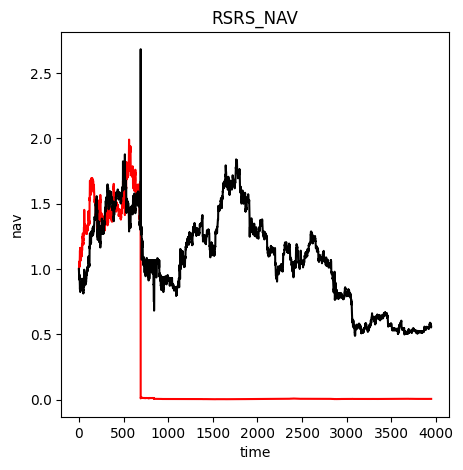

(-0.9434006188736931,
 1.3490418187244397,
 -0.6993116193875348,
 -0.4650613119201296,
 -0.3254579749465731,
 -0.886983869047188)

In [10]:
get_data(df_input,25,90,0.6,1)

In [11]:
df_s = pd.read_pickle(f"df_s.pkl" )
corr_all,corr_right,corr_left = corr_depict(df_s,'zscore')
re_ = df_s['nav'].iloc[-1]**(365.0*6/len(df_s.index)) - 1
std_ = np.std(df_s['pct'])*sqrt(365*6)

print(f"df_s.tail(2) :\n{df_s.tail(2)}")
print(f"re_ :\n{re_}")
print(f"std_ :\n{std_}")
print(f"re_/std_ :\n{re_/std_}")
print(f"corr_all :\n{corr_all}")
print(f"corr_right :\n{corr_right}")
print(f"corr_left :\n{corr_left}")


# re_,std_,re_/std_,corr_all,corr_right,corr_left

df_s.tail(2) :
          timestamp          open          high           low         close  \
3944  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
3945  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore            ma  signal  position  indicator       pct  \
3944  0.721573  0.162299  20752.213281     NaN       1.0          0  0.551776   
3945  0.706648  0.139154  20767.883268     NaN       1.0          0  0.558540   

           nav     x  
3944  0.005591  3944  
3945  0.005660  3945  
re_ :
-0.9434006188736931
std_ :
16.505887732580103
re_/std_ :
-0.05715540019162764
corr_all :
-0.4650613119201296
corr_right :
-0.3254579749465731
corr_left :
-0.886983869047188


In [5]:
def get_data(data,reg_window,stat_wid,thd,if_print): # 621 # 25  90  0.6  # 1
    cost_ = -0.0016
    # df_s = data.copy()
    # df_s['index'] = range(len(df_s))
    # # cal regression beta
    # df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
    # del df_s['index']
    # df_s = pd.read_csv("ds_reg_"+str(reg_window)+".csv")  # 25
    
    df_s = pd.read_pickle(f"df_i.pkl" ) # ds_reg_25.csv

    df_s['zscore'] = (df_s['beta']-df_s['beta'].rolling(stat_wid).mean())/df_s['beta'].rolling(stat_wid).std()

    df_s['ma'] = df_s['close'].rolling(60).mean()

    df_s.dropna(how='any',inplace=True)
    df_s.reset_index(drop=True,inplace=True)
    # print(df_s)
    # signal
    df_s['signal'] = np.nan
    # df_s['signal'] = np.where((df_s['zscore']>thd)&(df_s['close']>df_s['ma']),1,df_s['signal'])
    # df_s['signal'] = np.where((df_s['zscore'] < -thd)&(df_s['close']<df_s['ma']), -1, df_s['signal'])
    df_s['signal'] = np.where((df_s['zscore'] > thd), 1, df_s['signal'])
    df_s['signal'] = np.where((df_s['zscore'] < -thd), -1, df_s['signal'])

    df_s['position'] = df_s['signal']
    df_s['position'].iloc[0] = 0
    df_s['position'].fillna(method='pad',inplace=True)
    df_s['indicator'] = np.where(df_s['position']!=df_s['position'].shift(1),1,0)
    df_s['position'] = np.where(df_s['position']!=df_s['position'].shift(1),df_s['position'].shift(1),df_s['position'])
    # 是否可以做空
    # df_s['position'] = np.where(df_s['position']==-1,0,df_s['position'])

    df_s['pct'] = (df_s['close']/df_s['close'].shift(1) - 1)*df_s['position'] + df_s['indicator']*cost_
    std_ = np.std(df_s['pct'])*sqrt(365*6)
    df_s['nav'] = (df_s['pct'] + 1).cumprod()
    df_s['pct'] = df_s['close'] / df_s['close'].iloc[0]
    df_s['x'] = df_s.index
    # plot_average_cumulative_return(df_s, 'zscore', after=10, title='标准分未来10日上涨概率')
    # plot_average_cumulative_return(df_s, 'zscore', after=20, title='修正标准分未来10日期望收益', probability=False)
    
    df_s.to_pickle(f"df_s.pkl" )
    
    corr_all,corr_right,corr_left=corr_depict(df_s,'zscore')
    # plt.plot
    # df_s.to_csv(r"C:\Users\wangjian\Desktop\\data_result.csv",index=False)

    # 画图
    if if_print==1:
        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(df_s['nav'],'r-', label='strategy')
        ax1.plot(df_s['pct'],'k-', label='raw')
        plt.xlabel('time')
        plt.ylabel('nav')
        plt.title('RSRS_NAV')
        plt.show()
    # cal re,std_
    re_ = df_s['nav'].iloc[-1]**(365.0*6/len(df_s.index)) - 1
    # print(df_s['nav'].iloc[-1],len(df_s.index))

    # df_s.dropna(how='any',inplace=True)
    # stat_depict(df_s, 'beta')
    # stat_depict_plot(df_s, 'beta', 'distribution')
    # cal regression zscore

    return re_,std_,re_/std_,corr_all,corr_right,corr_left

In [5]:
def stat_depict_plot(df, col, title):
    df = df[~df[col].isna()].copy()

    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])

    plt.style.use('ggplot')
    # 画日对数收益率分布直方图
    fig = plt.figure(figsize=(18, 9))
    plt.suptitle(title)
    v = df[col]
    x = np.linspace(avgRet - 3 * stdRet, avgRet + 3 * stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(v)

    # plot the histogram
    plt.subplot(121)
    plt.hist(v, 50, weights=np.ones(len(v)) / len(v), alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()

def stat_depict(df, col, pr=True):
    df = df[~df[col].isna()].copy()
    # 计算总和的统计量
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    if pr:
        print(
            """
        平均数 : %.4f
        中位数 : %.4f
        标准差 : %.4f
        偏度   : %.4f
        峰度   : %.4f
        1 Standard Deviation : %.4f
        -1 Standard Deviation : %.4f
        """ % (avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet)
        )
    else:
        return dict(zip('平均数,中位数,标准差,偏度,峰度,1 Standard Deviation,-1 Standard Deviation'.split(','), map(lambda x: '{:.4%}'.format(x), [avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet])))

def plot_average_cumulative_return(df, factor_name, after=10, title=None, probability=True, prt=True):
    '''
    df 因子计算后的df
    factor_name df中因子的名称
    title 图标的标题
    after 之后N日
    probability True计算概率 False 计算平均收益
    '''
    RSRS = df[['close', factor_name]].copy()
    # 计算未来N日收益率
    RSRS['ret'] = RSRS.close.pct_change(after).shift(-after)
    group = pd.cut(RSRS[factor_name], 50)
    RSRS['group'] = group
    if probability:
        # 计算上涨概率
        after_ret = RSRS.groupby('group')['ret'].apply(lambda x: np.sum(np.where(x > 0, 1, 0)) / len(x))
    else:
        after_ret = RSRS.groupby('group')['ret'].mean()

    if prt:
        # 画图
        plt.figure(figsize=(18, 6))
        # 设置标题
        plt.title(title)
        size = len(after_ret)
        plt.bar(range(size), after_ret.values, width=0.8, alpha=0.5)
        # rotation旋转x轴标签
        plt.xticks(range(size), after_ret.index.categories.right, rotation=30)
        # 设置y轴标题
        plt.ylabel('上涨概率')
        plt.show()
    else:
        return after_ret

In [6]:
def corr_depict(df,col_name):
    df_s = df.copy()
    corr_t_wid = 20
    df_s['ret'] = df_s.close.pct_change(corr_t_wid).shift(-corr_t_wid)
    zr_df = plot_average_cumulative_return(df_s, col_name, after=corr_t_wid, prt=False, probability=False)
    zr_df.index = zr_df.index.categories.right
    zr_df = zr_df.fillna(0)
    zr_df = zr_df.reset_index()
    zr_df.columns = ['factor', 'ret']

    rq = zr_df.query('factor>0')
    cor_right = np.corrcoef(rq['factor'], rq['ret'])[0][1]

    rq = zr_df.query('factor<0')
    cor_left = np.corrcoef(rq['factor'], rq['ret'])[0][1]

    rq = zr_df
    cor_all = np.corrcoef(rq['factor'], rq['ret'])[0][1]
    return cor_all,cor_right,cor_left


In [ ]:
def loading_data(cate_id):
    sql_str = "SELECT ymd+' '+hms,[open],high,low,[close]  FROM [test_block].[dbo].[adj_data]" \
              "  where category = '"+str(cate_id)+"' and window=240  and ymd>'2020-12-31' order by ymd,hms"
    cursor.execute(sql_str)
    df_id = pd.DataFrame(cursor.fetchall(), columns=['timestamp','open','high','low','close'])
    # print(df_id)
    return df_id

In [ ]:
if __name__ == '__main__':
    # parameter
    if_print = 1
    reg_wid = 10 + (np.arange(10)) * 5      # 10 #  [10 15 20 25 30 35 40 45 50 55]
    stat_wid = 60 + (np.arange(10)) * 30    # 10 #  [60 90 120 150 180 210 240 270 300 330]
    threshold = 0.5 + (np.arange(20)) * 0.1 # 20 #  [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2  2.3 2.4]

    # df_input = loading_data('btc')
    df_para = pd.DataFrame(list(product(reg_wid, stat_wid,threshold))) # 2000 10*10*20 : 10 60 0.5
    df_para['re'] = np.nan
    df_para['std'] = np.nan
    df_para['sr'] = np.nan
    df_para['corr_all'] = np.nan
    df_para['corr_right'] = np.nan
    df_para['corr_left'] = np.nan

    for i_reg in reg_wid:               # 10 #  [10 15 20 25 30 35 40 45 50 55]
        print("reg_para:",i_reg)
        get_regression(df_input, i_reg) # 25

    for index_para,row_para in tqdm(df_para.iterrows(),total=len(df_para.index)): # 2000 10*10*20 : 10 60 0.5
        # print(row) 
        if index_para!=621:  # 621 # 25  90  0.6  
            continue
        df_para['re'].iloc[index_para],df_para['std'].iloc[index_para],df_para['sr'].iloc[index_para], df_para['corr_all'].iloc[index_para],df_para['corr_right'].iloc[index_para],df_para['corr_left'].iloc[index_para] \
            = get_data(df_input, int(row_para[0]), int(row_para[1]), row_para[2], if_print) 
            # 621 # 25  90  0.6  # 1
            
            # return re_,std_,re_/std_,corr_all,corr_right,corr_left
            
        # df_para.to_csv(r"rsrs_adj_with_ma.csv")
        
        break
    # print(df_para)